In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
import category_encoders as ce

In [2]:
# Training parameters
TRAIN_FRAC = 0.8 # fraction of the labeled data to use for training, remainder is used for validation
RANDOM_STATE = 1 # random state for random sampling 

In [3]:
# Load data
train_data_all = pd.read_csv('data/train_values.csv')
label_data_all = pd.read_csv('data/train_labels.csv')
test_data_all = pd.read_csv('data/test_values.csv')

In [4]:
# Compare totals for each category
val_counts = label_data_all['damage_grade'].value_counts()
val_counts

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64

In [57]:
# Undersample the majority classes
n_1, n_2, n_3 = val_counts[1], val_counts[2], val_counts[3]

sample_to = 1 # choose 1 or 3
mult_factor = .85

train_data_drop = train_data_all.copy()
if sample_to == 1:
    # sample 2 and 3 down to n_1
    label_3_inds = label_data_all.index[label_data_all['damage_grade']==3].to_list()
    label_2_inds = label_data_all.index[label_data_all['damage_grade']==2].to_list()
    drop_3 = np.random.choice(label_3_inds, int((len(label_3_inds)-n_1)*mult_factor), replace=False)
    drop_2 = np.random.choice(label_2_inds, len(drop_3)+(n_2-n_3), replace=False)
    print('Dropping -- 3: {}, 2: {}'.format(len(drop_3),len(drop_2)))
    train_data_drop.drop(drop_3,axis=0,inplace=True)
    train_data_drop.drop(drop_2,axis=0,inplace=True)
    label_data_drop = label_data_all.copy()
    label_data_drop.drop(drop_3,axis=0,inplace=True)
    label_data_drop.drop(drop_2,axis=0,inplace=True)
elif sample_to == 3:
    # sample 2 down to n_3
    label_2_inds = label_data_all.index[label_data_all['damage_grade']==2].to_list()
    drop_2 = np.random.choice(label_2_inds, len(label_2_inds)-int(n_3*mult_factor), replace=False)
    print('Dropping -- 2: {}'.format(len(drop_2)))
    train_data_drop.drop(drop_2,axis=0,inplace=True)
    label_data_drop = label_data_all.copy()
    label_data_drop.drop(drop_2,axis=0,inplace=True)

new_val_counts = label_data_drop['damage_grade'].value_counts()
new_val_counts

Dropping -- 3: 52779, 2: 113820


3    34439
2    34439
1    25124
Name: damage_grade, dtype: int64

In [58]:
# Inspect columns
train_data_drop.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

In [59]:
# categorical variables
# cat_enc = ce.hashing.HashingEncoder(verbose=2)
# cat_enc = ce.one_hot.OneHotEncoder()
cat_enc = ce.helmert.HelmertEncoder()
cat_cols = [train_data_drop.columns[kk] for kk in range(len(train_data_drop.columns)) if train_data_drop[train_data_drop.columns[kk]].dtypes=='object']
print(cat_cols)
train_data_cat = train_data_drop.copy()
cat_results = cat_enc.fit_transform(train_data_drop[cat_cols])

['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']


In [60]:
train_data_cat.drop(cat_cols,axis=1,inplace=True)
print(train_data_cat.shape)

(94002, 31)


In [61]:
cat_results.index = train_data_drop.index
train_data_cat[cat_results.columns] = cat_results
print(train_data_cat.shape)

(94002, 62)


In [84]:
# prepare test set in the same way
test_data_cat = test_data_all.copy()
test_cat_results = cat_enc.transform(test_data_cat[cat_cols])
test_data_cat.drop(cat_cols,axis=1,inplace=True)
test_cat_results.index = test_data_cat.index
test_data_cat[test_cat_results.columns] = test_cat_results

In [81]:
test_data_cat[cat_cols]
test_cat_results

,intercept,land_surface_condition_0,land_surface_condition_1,foundation_type_0,foundation_type_1,foundation_type_2,foundation_type_3,roof_type_0,roof_type_1,ground_floor_type_0,...,plan_configuration_2,plan_configuration_3,plan_configuration_4,plan_configuration_5,plan_configuration_6,plan_configuration_7,plan_configuration_8,legal_ownership_status_0,legal_ownership_status_1,legal_ownership_status_2
0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,2.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,2.0,-1.0
86864,1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
86865,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
86866,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0


In [62]:
print('All finite in training? ',train_data_drop.notnull().values.all())
print('Any NaN in training? ',train_data_drop.isnull().values.any())
print('All finite in cat? ',train_data_cat.notnull().values.all())
print('Any NaN in cat? ',train_data_cat.isnull().values.any())

All finite in training?  True
Any NaN in training?  False
All finite in cat?  True
Any NaN in cat?  False


In [63]:
(train_data_cat.dtypes == 'int64').all()

False

In [64]:
# Split into training and validation sets
data_train_unscaled = train_data_cat.sample(frac=TRAIN_FRAC,random_state=RANDOM_STATE)
data_val_unscaled = train_data_cat.drop(data_train_unscaled.index,axis=0)
label_train = label_data_drop.sample(frac=TRAIN_FRAC,random_state=RANDOM_STATE)
label_val = label_data_drop.drop(label_train.index,axis=0)

In [65]:
# Scale the training data
#mm_scaler = preprocessing.StandardScaler()
#scale_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
#              'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']
#data_train = data_train_unscaled.copy()
#data_train[scale_cols] = mm_scaler.fit_transform(data_train[scale_cols])
#data_val = data_val_unscaled.copy()
#data_val[scale_cols] = mm_scaler.transform(data_val[scale_cols])

In [66]:
# compute class weights
class_weights = compute_class_weight('balanced',
                                    classes=np.unique(label_train['damage_grade'].values),
                                    y=label_train['damage_grade'].values)
weights_dict = {np.unique(label_train['damage_grade'].values)[kk]:class_weights[kk] for kk in range(len(class_weights))}
weights_dict

{1: 1.2449631653008857, 2: 0.9106122251283542, 3: 0.9102484960722369}

In [67]:
# Train the classifier
cl_f = RandomForestClassifier(random_state = 1)
n_estimators = [875,900,925]
max_depth = [35, 36, 37]
min_samples_split = [5]
min_samples_leaf = [1] 

hyper_f = dict(n_estimators = n_estimators, 
               max_depth = max_depth,
               min_samples_split = min_samples_split,
               min_samples_leaf = min_samples_leaf)
grid_f = GridSearchCV(cl_f, hyper_f, cv = 3, verbose = 2, 
                      n_jobs = -1)
best_f = grid_f.fit(data_train_unscaled.values.astype(float), label_train.values[:,1].astype(int))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  27 | elapsed:  1.3min remaining: 15.9min
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:  1.3min remaining:   55.4s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.4min finished


In [75]:
# Evaluate the classifier
pred_val = best_f.predict(data_val_unscaled)
print(classification_report(label_val.values[:,1], pred_val))

              precision    recall  f1-score   support

           1       0.77      0.76      0.76      4989
           2       0.61      0.59      0.60      6911
           3       0.71      0.75      0.73      6900

    accuracy                           0.69     18800
   macro avg       0.70      0.70      0.70     18800
weighted avg       0.69      0.69      0.69     18800



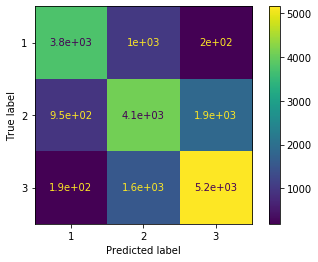

In [69]:
plot_confusion_matrix(best_f,data_val_unscaled,label_val.values[:,1].astype(int))

In [70]:
best_f.best_params_

{'max_depth': 36,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 925}

In [ ]:
# predict from test set
pred_test = best_f.predict(test_data_cat)

In [93]:
pred_test_df = pd.DataFrame(test_data_cat.building_id,columns=['building_id'])
pred_test_df['damage_grade'] = pred_test
pred_test_df.to_csv('data/submission.csv',index=False)

In [86]:
test_data_cat.building_id

0         300051
1          99355
2         890251
3         745817
4         421793
          ...   
86863     310028
86864     663567
86865    1049160
86866     442785
86867     501372
Name: building_id, Length: 86868, dtype: int64